In [14]:
import pickle as pkl
from random import seed

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib.patches import Patch
from sklearn.manifold import TSNE
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

from scastral import *

seed(1234)
np.random.seed(1234)
torch.random.manual_seed(1234)


In [15]:
train = pd.read_csv('data/train_set.csv')
train.set_index('0',inplace=True,drop=True)  # set barcodes as index
labels = np.array(train['label'])  #  get labels
del train['label']

#### load afatinib drug response singature

In [16]:
signature = pd.read_csv('data/signature.csv')
signature = list(signature['ensembl_gene_id'])

#### Preprocessing ( filtering, normalization and feature selection)

In [17]:
X = pd.DataFrame(train,columns=train.columns,index=train.index)
train = X.loc[:,signature] # subset to signature

#### Train the model

In [23]:

preprocessing_pipe = Pipeline([ ('gf-icf',preprocessing.GfIcfTransformer()),('scaler',MinMaxScaler())])
clf = SVC(C=1,kernel=cosine_similarity,probability=True,class_weight='balanced',random_state=123)
scastral = network.SCAstral(max_epochs=250, patience=20, batch_size=8,
                            input_size=train.shape[1], hidden_size=64, latent_size=32,
                            alfa=1, mu=2, theta=.1, lr=1e-5,
                            predictor=clf, scorer=make_scorer(accuracy_score),
                            verbose=False, path='models/scmuta.pt')

X = preprocessing_pipe.fit_transform(train)
X = scastral.fit_transform(X,labels)
clf.fit(X,labels)

pipe = Pipeline([('preprocessing',preprocessing_pipe),('feature_extraction',scastral),('clf',clf)])
pkl.dump(pipe,open('models/scastral_svm_test1.pkl','wb'))


best epoch 1


In [20]:
train

,ENSG00000013588,ENSG00000115457,ENSG00000137673,ENSG00000182899,ENSG00000204525,ENSG00000026025,ENSG00000162545,ENSG00000206503,ENSG00000234745,ENSG00000212993,...,ENSG00000184207,ENSG00000179059,ENSG00000077152,ENSG00000229989,ENSG00000138430,ENSG00000171320,ENSG00000177508,ENSG00000225383,ENSG00000116991,ENSG00000109089
0,,,,,,,,,,,,,,,,,,,,,
CTR01_AAACGAACACGGTCTG,0.000000,62.251703,0.000000,186.755109,62.251703,622.517030,0.000000,124.503406,0.000000,0.000000,...,62.251703,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,124.503406,0.000000
CTR01_AAACGAACAGAATTCC,48.165731,361.242984,0.000000,2769.529543,288.994387,1276.391876,168.580059,120.414328,72.248597,0.000000,...,120.414328,0.0,361.242984,0.000000,264.911522,72.248597,144.497194,48.165731,120.414328,0.000000
CTR01_AAAGAACTCACCTCAC,0.000000,172.037730,21.504716,2860.127263,236.551879,2085.957478,215.047163,344.075460,236.551879,0.000000,...,193.542446,0.0,408.589609,0.000000,516.113190,43.009433,150.533014,21.504716,64.514149,0.000000
CTR01_AAAGGTACAATGGGTG,0.000000,210.100822,0.000000,5205.831471,513.579786,256.789893,70.033607,256.789893,163.411750,23.344536,...,93.378143,0.0,163.411750,0.000000,210.100822,0.000000,163.411750,116.722679,93.378143,46.689071
CTR01_AACAAAGAGGTCTTTG,0.000000,574.104621,0.000000,2097.689960,264.971363,596.185568,66.242841,507.861780,132.485682,0.000000,...,198.728523,0.0,242.890416,0.000000,242.890416,0.000000,154.566629,88.323788,132.485682,22.080947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTR02_TTTGGAGTCGGCCAAC,0.000000,0.000000,0.000000,0.000000,136.980968,821.885805,0.000000,479.433386,136.980968,0.000000,...,0.000000,0.0,68.490484,0.000000,136.980968,0.000000,0.000000,0.000000,68.490484,68.490484
CTR02_TTTGGTTCAATACCTG,0.000000,0.000000,0.000000,64.718662,64.718662,0.000000,64.718662,64.718662,0.000000,0.000000,...,0.000000,0.0,0.000000,64.718662,0.000000,0.000000,0.000000,0.000000,64.718662,0.000000
CTR02_TTTGTTGAGGAGATAG,907.042290,53.355429,106.710858,1280.530292,1173.819435,160.066287,480.198860,1654.018294,2187.572583,0.000000,...,53.355429,0.0,0.000000,0.000000,640.265146,0.000000,160.066287,0.000000,0.000000,0.000000


#### Compare inter and intra cluster distance before and after training

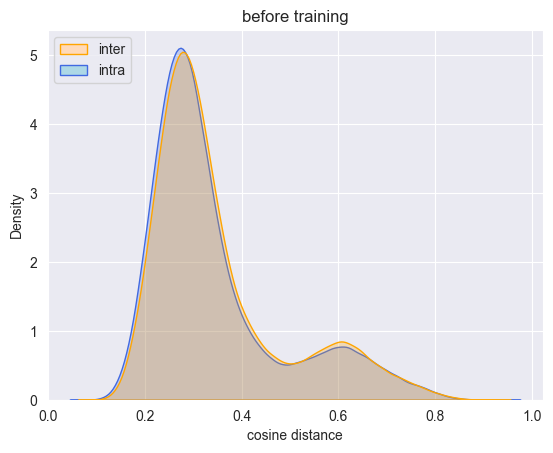

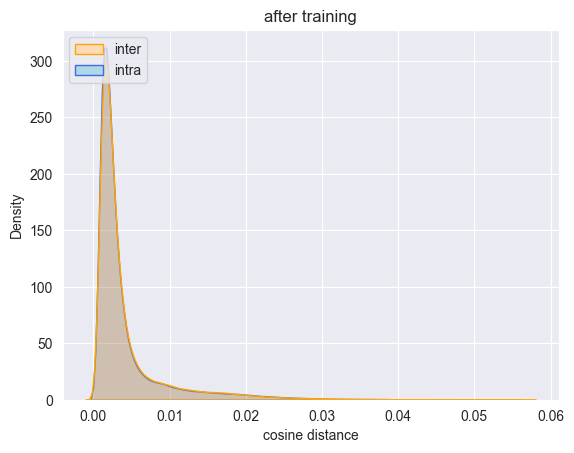

In [22]:

data = pipe[0].transform(train)
transformed = pipe[1].transform(data)
mask = np.array(labels, dtype=bool)

# compute cosine distance before transformation
sxsb = cosine_distances(data[mask, :])  # survived on survived
sxdb = cosine_distances(data[mask, :], data[~mask, :])  # survived on dead
dxdb = cosine_distances(data[~mask, :])  # dead on dead

# compute cosine distance after transformation
sxsa = cosine_distances(transformed[mask, :])  # survived on survived
sxda = cosine_distances(transformed[mask, :], transformed[~mask, :])  # survived on dead
dxda = cosine_distances(transformed[~mask, :])  # dead on dead

np.fill_diagonal(sxsb, np.nan)  # remove diagonal elements
np.fill_diagonal(sxdb, np.nan)  # remove diagonal elements
np.fill_diagonal(dxdb, np.nan)  # remove diagonal elements
np.fill_diagonal(sxsa, np.nan)  # remove diagonal elements
np.fill_diagonal(sxda, np.nan)  # remove diagonal elements
np.fill_diagonal(dxda, np.nan)  # remove diagonal elements

# flatten distance matrix
inter_b = sxdb.flatten()
intra_b = np.concatenate((sxsb.flatten(), dxdb.flatten()))
inter_a = sxda.flatten()
intra_a = np.concatenate((sxsa.flatten(), dxda.flatten()))

# plot distribution before transformation
sns.kdeplot(intra_b, color='royalblue', fill=True, legend='intra')
sns.kdeplot(inter_b, color='orange', fill=True, legend='inter')
plt.title('before training')
plt.xlabel('cosine distance')
legend_elements = [Patch(facecolor='peachpuff', edgecolor='orange',
                         label='inter'), Patch(facecolor='lightblue', edgecolor='royalblue',
                                               label='intra')]
plt.legend(handles=legend_elements, loc='upper left')
plt.show()

# plot distribution after transformation
sns.kdeplot(intra_a, color='royalblue', fill=True, legend='intra')
sns.kdeplot(inter_a, color='orange', fill=True, legend='inter')
plt.title('after training')
plt.xlabel('cosine distance')
plt.legend(handles=legend_elements, loc='upper left')
plt.show()

## Visualize Data

In [ ]:
toplot = TSNE(n_components=2).fit_transform(X)
#plt.axes().set_facecolor(color='white')
scatter = plt.scatter(toplot[:,0],toplot[:,1],c=labels,cmap='Set1',s=5)
scatter.legend_elements(prop='colors', num=2)
handles = scatter.legend_elements(prop="colors")[0]
plt.legend(handles=handles,labels=['resistenti','vulnerabili'],loc='upper left')#, bbox_to_anchor=(0, 0))
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.show()

In [ ]:
model = pkl.load(open('models/scastral_svm.pkl', 'rb'))
preprocessed = model[0].transform(train)
# %%

net = model[1][0]
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

toplot = TSNE(n_components=2, perplexity=5, n_jobs=-1).fit_transform(net.transform(preprocessed))
scatter = plt.scatter(toplot[:, 0], toplot[:, 1], c=labels, cmap='Set1', s=5)
scatter.legend_elements(prop='colors', num=2)
handles = scatter.legend_elements(prop="colors")[0]
plt.legend(handles=handles, labels=['resistenti', 'vulnerabili'], loc='upper left')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.show()